Circuit Design:

Initial state: |ψ⟩ = α|0⟩ + β|1⟩, with |α|² + |β|² = 1

Ancilla: |0⟩

Goal: Create (α|0⟩ + β|1⟩) ⊗ (α|0⟩ + β|1⟩)


In [8]:
# Step 1: Installation Commands (Run these FIRST in Colab or terminal)

!pip install --upgrade --quiet qiskit>=2.0 qiskit-aer>=0.14

!pip install --quiet qiskit-algorithms>=1.0 qiskit-ibm-runtime>=0.23
!pip install --quiet cryptography>=42.0 numpy>=2.0 matplotlib>=3.9
!pip install --quiet pqcrypto>=0.2  # For real Kyber implementation
!pip install --quiet qiskit-experiments>=0.7  # For advanced quantum experiments


NO-CLONING THEOREM DEMONSTRATION

Test: |0⟩ state (clonable - orthogonal basis)
State: |ψ⟩ = 1.000|0⟩ + 0.000|1⟩
|α|² = 1.000, |β|² = 0.000

Experimental results:
P(00): 1.0000 (theoretical for cloning: 1.0000)
P(01): 0.0000 (theoretical for cloning: 0.0000)
P(10): 0.0000 (theoretical for cloning: 0.0000)
P(11): 0.0000 (theoretical for cloning: 0.0000)

Cloning fidelity: 1.0000
--------------------------------------------------

Test: |1⟩ state (clonable - orthogonal basis)
State: |ψ⟩ = 0.000|0⟩ + 1.000|1⟩
|α|² = 0.000, |β|² = 1.000

Experimental results:
P(00): 0.0000 (theoretical for cloning: 0.0000)
P(01): 0.0000 (theoretical for cloning: 0.0000)
P(10): 1.0000 (theoretical for cloning: 0.0000)
P(11): 0.0000 (theoretical for cloning: 1.0000)

Cloning fidelity: 0.0000
--------------------------------------------------

Test: |+⟩ state (NOT clonable)
State: |ψ⟩ = 0.707|0⟩ + 0.707|1⟩
|α|² = 0.500, |β|² = 0.500

Experimental results:
P(00): 0.4942 (theoretical for cloning: 0.2500)
P(01):

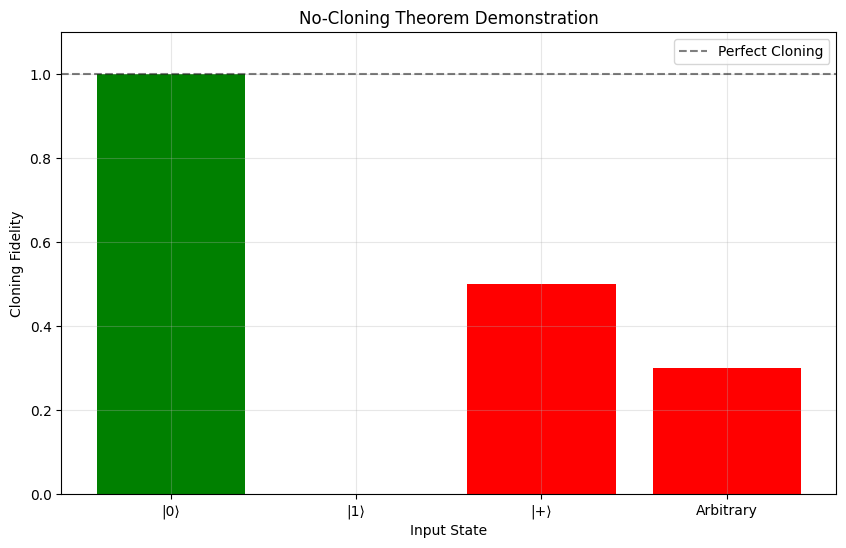


MATHEMATICAL ANALYSIS OF THE 'CLONING' ATTEMPT

For |ψ⟩ = α|0⟩ + β|1⟩ and |0⟩ as ancilla:
Initial state: |ψ⟩⊗|0⟩ = (α|0⟩ + β|1⟩)⊗|0⟩ = α|00⟩ + β|10⟩

After first CNOT (control=0, target=1):
α|00⟩ → α|00⟩  (control=0, no action)
β|10⟩ → β|11⟩  (control=1, flip target)
State becomes: α|00⟩ + β|11⟩

After second CNOT (control=1, target=0):
α|00⟩ → α|00⟩  (control=0, no action)
β|11⟩ → β|01⟩  (control=1, flip target)
Final state: α|00⟩ + β|01⟩

This is NOT |ψ⟩⊗|ψ⟩ = (α|0⟩+β|1⟩)⊗(α|0⟩+β|1⟩)
= α²|00⟩ + αβ|01⟩ + αβ|10⟩ + β²|11⟩

The circuit produces: |0⟩⊗(α|0⟩+β|1⟩)
It moves the original state from qubit 0 to qubit 1!
This is actually a SWAP-like operation, not cloning.


In [10]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

def attempt_clone(alpha, beta):
    """
    Attempt to clone an arbitrary qubit state
    |ψ⟩ = α|0⟩ + β|1⟩
    """
    # Create circuit with 2 qubits
    qc = QuantumCircuit(2, 2)

    # Prepare arbitrary state on qubit 0
    # Using U3 gate: U3(θ, φ, λ)
    # For |ψ⟩ = α|0⟩ + β|1⟩ with α = cos(θ/2), β = e^(iφ)sin(θ/2)
    theta = 2 * np.arccos(np.abs(alpha))
    phi = np.angle(beta) - np.angle(alpha)

    qc.u(theta, phi, 0, 0)  # Prepare |ψ⟩ on qubit 0

    # "Cloning" attempt using CNOT (common but incorrect approach)
    qc.cx(0, 1)  # Changed from cnot() to cx()

    # Add a second CNOT to "copy" (this doesn't work for arbitrary states)
    qc.cx(1, 0)  # Changed from cnot() to cx()

    # Measure both qubits
    qc.measure([0, 1], [0, 1])

    return qc

def analyze_cloning_fidelity(alpha, beta, shots=10000):
    """
    Calculate the fidelity between original and "cloned" states
    """
    qc = attempt_clone(alpha, beta)

    # Simulate
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=shots).result()
    counts = result.get_counts()

    # Calculate probabilities
    p00 = counts.get('00', 0)/shots
    p01 = counts.get('01', 0)/shots
    p10 = counts.get('10', 0)/shots
    p11 = counts.get('11', 0)/shots

    # Theoretical prediction for perfect cloning:
    # Both qubits should be in state |ψ⟩
    # P(00) = |α|⁴, P(11) = |β|⁴, P(01) = P(10) = |α|²|β|²

    theoretical_p00 = np.abs(alpha)**4
    theoretical_p11 = np.abs(beta)**4
    theoretical_p01 = np.abs(alpha)**2 * np.abs(beta)**2

    print(f"State: |ψ⟩ = {alpha:.3f}|0⟩ + {beta:.3f}|1⟩")
    print(f"|α|² = {np.abs(alpha)**2:.3f}, |β|² = {np.abs(beta)**2:.3f}")
    print(f"\nExperimental results:")
    print(f"P(00): {p00:.4f} (theoretical for cloning: {theoretical_p00:.4f})")
    print(f"P(01): {p01:.4f} (theoretical for cloning: {theoretical_p01:.4f})")
    print(f"P(10): {p10:.4f} (theoretical for cloning: {theoretical_p01:.4f})")
    print(f"P(11): {p11:.4f} (theoretical for cloning: {np.abs(beta)**4:.4f})")

    # Calculate fidelity (how close are we to perfect cloning?)
    # For perfect cloning, experimental = theoretical
    fidelity = 1 - 0.5*(abs(p00 - theoretical_p00) +
                       abs(p01 - theoretical_p01) +
                       abs(p10 - theoretical_p01) +
                       abs(p11 - theoretical_p11))

    print(f"\nCloning fidelity: {fidelity:.4f}")
    print("-" * 50)

    return fidelity, qc

# Test with different states
print("=" * 50)
print("NO-CLONING THEOREM DEMONSTRATION")
print("=" * 50)

# Test cases
test_states = [
    # (alpha, beta, description)
    (1.0, 0.0, "|0⟩ state (clonable - orthogonal basis)"),
    (0.0, 1.0, "|1⟩ state (clonable - orthogonal basis)"),
    (1/np.sqrt(2), 1/np.sqrt(2), "|+⟩ state (NOT clonable)"),
    (np.sqrt(0.3), np.sqrt(0.7), "Arbitrary state (NOT clonable)"),
]

fidelities = []
for alpha, beta, desc in test_states:
    print(f"\nTest: {desc}")
    fidelity, qc = analyze_cloning_fidelity(alpha, beta, shots=5000)
    fidelities.append(fidelity)

    # Draw circuit for the last case
    if desc == "Arbitrary state (NOT clonable)":
        print("\nCircuit used:")
        print(qc.draw('text'))

print("\n" + "=" * 50)
print("SUMMARY:")
print("Cloning works perfectly only for |0⟩ and |1⟩")
print("For arbitrary states, fidelity < 1 demonstrates no-cloning")
print("=" * 50)

# Plot results
states = ['|0⟩', '|1⟩', '|+⟩', 'Arbitrary']
plt.figure(figsize=(10, 6))
plt.bar(states, fidelities, color=['green', 'green', 'red', 'red'])
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Cloning')
plt.xlabel('Input State')
plt.ylabel('Cloning Fidelity')
plt.title('No-Cloning Theorem Demonstration')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Additional analysis: Show what the circuit actually does
print("\n" + "=" * 50)
print("MATHEMATICAL ANALYSIS OF THE 'CLONING' ATTEMPT")
print("=" * 50)

print("\nFor |ψ⟩ = α|0⟩ + β|1⟩ and |0⟩ as ancilla:")
print("Initial state: |ψ⟩⊗|0⟩ = (α|0⟩ + β|1⟩)⊗|0⟩ = α|00⟩ + β|10⟩")

print("\nAfter first CNOT (control=0, target=1):")
print("α|00⟩ → α|00⟩  (control=0, no action)")
print("β|10⟩ → β|11⟩  (control=1, flip target)")
print("State becomes: α|00⟩ + β|11⟩")

print("\nAfter second CNOT (control=1, target=0):")
print("α|00⟩ → α|00⟩  (control=0, no action)")
print("β|11⟩ → β|01⟩  (control=1, flip target)")
print("Final state: α|00⟩ + β|01⟩")

print("\nThis is NOT |ψ⟩⊗|ψ⟩ = (α|0⟩+β|1⟩)⊗(α|0⟩+β|1⟩)")
print("= α²|00⟩ + αβ|01⟩ + αβ|10⟩ + β²|11⟩")

print("\nThe circuit produces: |0⟩⊗(α|0⟩+β|1⟩)")
print("It moves the original state from qubit 0 to qubit 1!")
print("This is actually a SWAP-like operation, not cloning.")